In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
import emoji
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch

# Cek apakah CUDA tersedia
is_cuda_available = torch.cuda.is_available()
print(f"CUDA tersedia: {is_cuda_available}")

# Jika tersedia, tampilkan jumlah GPU yang terdeteksi
if is_cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Jumlah GPU yang terdeteksi: {num_gpus}")
    for i in range(num_gpus):
        print(f"Nama GPU {i}: {torch.cuda.get_device_name(i)}")

CUDA tersedia: True
Jumlah GPU yang terdeteksi: 1
Nama GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
# Import transformers library for BERT
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Download dataset
file_id = '1djsZEhQo2WrLIPDFs-JDIUBsQTYfXCOa'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'spam.csv', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1djsZEhQo2WrLIPDFs-JDIUBsQTYfXCOa
To: c:\LABTI_3ia01\bert_EmailSpam\spam.csv
100%|██████████| 480k/480k [00:00<00:00, 3.89MB/s]


'spam.csv'

In [6]:
# Load dataset
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['Category', 'Message']]
df.columns = ['Category', 'Message']

In [7]:
# Preprocess the data
# Encode labels
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [8]:
# Convert 'Message' to lowercase, remove HTML, URLs, punctuation, and emojis
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = BeautifulSoup(text, 'html.parser').get_text()  # Remove HTML
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = emoji.demojize(text)  # Remove emojis
    return text

df['Message'] = df['Message'].apply(preprocess_text)

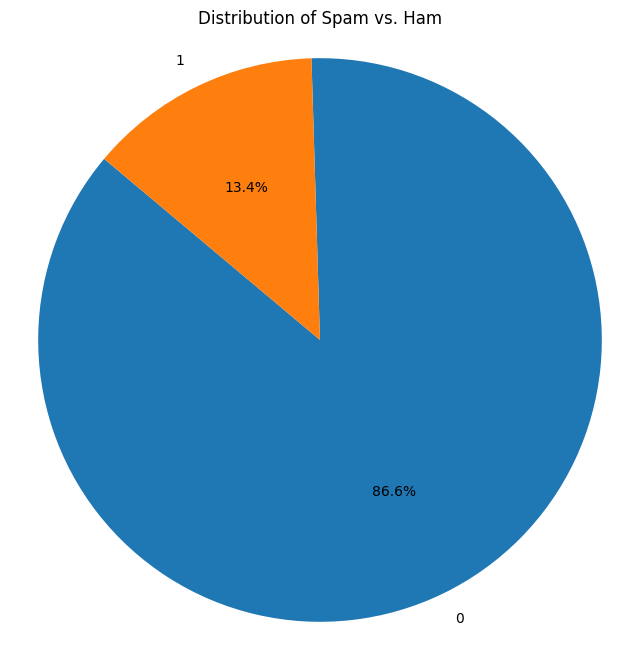

In [9]:
# Plot label distribution
category_counts = df['Category'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam vs. Ham')
plt.axis('equal')
plt.show()

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.2, random_state=42)

In [11]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
# Create a custom dataset class for BERT
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [13]:
# Prepare datasets and dataloaders
train_dataset = SpamDataset(X_train, y_train, tokenizer)
test_dataset = SpamDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [14]:
# Load BERT model for sequence classification and move it to the device
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

In [ ]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
    }
)

In [17]:
# Train the model
trainer.train()

  1%|          | 11/1116 [00:01<02:44,  6.73it/s]

{'loss': 0.5511, 'grad_norm': 6.892651081085205, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}


  2%|▏         | 21/1116 [00:03<02:41,  6.77it/s]

{'loss': 0.5643, 'grad_norm': 6.563028812408447, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}


  3%|▎         | 31/1116 [00:04<02:38,  6.85it/s]

{'loss': 0.5154, 'grad_norm': 5.4216790199279785, 'learning_rate': 3e-06, 'epoch': 0.05}


  4%|▎         | 41/1116 [00:06<02:38,  6.77it/s]

{'loss': 0.4517, 'grad_norm': 5.219562530517578, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.07}


  5%|▍         | 51/1116 [00:07<02:36,  6.79it/s]

{'loss': 0.3879, 'grad_norm': 4.2257232666015625, 'learning_rate': 5e-06, 'epoch': 0.09}


  5%|▌         | 61/1116 [00:09<02:32,  6.91it/s]

{'loss': 0.321, 'grad_norm': 5.545107841491699, 'learning_rate': 6e-06, 'epoch': 0.11}


  6%|▋         | 71/1116 [00:10<02:33,  6.79it/s]

{'loss': 0.2937, 'grad_norm': 5.043980121612549, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.13}


  7%|▋         | 81/1116 [00:12<02:29,  6.94it/s]

{'loss': 0.214, 'grad_norm': 3.9862523078918457, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.14}


  8%|▊         | 91/1116 [00:13<02:27,  6.94it/s]

{'loss': 0.1948, 'grad_norm': 2.6847903728485107, 'learning_rate': 9e-06, 'epoch': 0.16}


  9%|▉         | 101/1116 [00:14<02:28,  6.85it/s]

{'loss': 0.0963, 'grad_norm': 17.487245559692383, 'learning_rate': 1e-05, 'epoch': 0.18}


 10%|▉         | 111/1116 [00:16<02:29,  6.74it/s]

{'loss': 0.0974, 'grad_norm': 1.970000982284546, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.2}


 11%|█         | 121/1116 [00:17<02:24,  6.91it/s]

{'loss': 0.0601, 'grad_norm': 17.388381958007812, 'learning_rate': 1.2e-05, 'epoch': 0.22}


 12%|█▏        | 131/1116 [00:19<02:22,  6.92it/s]

{'loss': 0.1971, 'grad_norm': 0.28641921281814575, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.23}


 13%|█▎        | 141/1116 [00:20<02:22,  6.82it/s]

{'loss': 0.0745, 'grad_norm': 0.3143794536590576, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.25}


 14%|█▎        | 151/1116 [00:22<02:18,  6.98it/s]

{'loss': 0.0414, 'grad_norm': 0.26672545075416565, 'learning_rate': 1.5e-05, 'epoch': 0.27}


 14%|█▍        | 161/1116 [00:23<02:17,  6.95it/s]

{'loss': 0.0624, 'grad_norm': 30.823701858520508, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.29}


 15%|█▌        | 171/1116 [00:25<02:23,  6.61it/s]

{'loss': 0.2122, 'grad_norm': 6.124544620513916, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.3}


 16%|█▌        | 181/1116 [00:26<02:19,  6.72it/s]

{'loss': 0.1109, 'grad_norm': 0.3820444643497467, 'learning_rate': 1.8e-05, 'epoch': 0.32}


 17%|█▋        | 191/1116 [00:28<02:24,  6.40it/s]

{'loss': 0.0594, 'grad_norm': 0.16336487233638763, 'learning_rate': 1.9e-05, 'epoch': 0.34}


 18%|█▊        | 201/1116 [00:29<02:13,  6.87it/s]

{'loss': 0.2065, 'grad_norm': 47.10620880126953, 'learning_rate': 2e-05, 'epoch': 0.36}


 19%|█▉        | 211/1116 [00:30<02:09,  6.98it/s]

{'loss': 0.1857, 'grad_norm': 20.55942726135254, 'learning_rate': 2.1e-05, 'epoch': 0.38}


 20%|█▉        | 221/1116 [00:32<02:13,  6.70it/s]

{'loss': 0.2642, 'grad_norm': 57.858272552490234, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.39}


 21%|██        | 231/1116 [00:33<02:10,  6.80it/s]

{'loss': 0.0535, 'grad_norm': 0.19480189681053162, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.41}


 22%|██▏       | 241/1116 [00:35<02:08,  6.84it/s]

{'loss': 0.16, 'grad_norm': 1.4258486032485962, 'learning_rate': 2.4e-05, 'epoch': 0.43}


 22%|██▏       | 251/1116 [00:36<02:06,  6.84it/s]

{'loss': 0.127, 'grad_norm': 0.18897157907485962, 'learning_rate': 2.5e-05, 'epoch': 0.45}


 23%|██▎       | 261/1116 [00:38<02:06,  6.74it/s]

{'loss': 0.1566, 'grad_norm': 4.875131130218506, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.47}


 24%|██▍       | 271/1116 [00:39<02:04,  6.80it/s]

{'loss': 0.0768, 'grad_norm': 0.1501820832490921, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.48}


 25%|██▌       | 281/1116 [00:41<02:02,  6.80it/s]

{'loss': 0.0292, 'grad_norm': 0.2409248650074005, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.5}


 26%|██▌       | 291/1116 [00:42<02:00,  6.87it/s]

{'loss': 0.0867, 'grad_norm': 0.09384557604789734, 'learning_rate': 2.9e-05, 'epoch': 0.52}


 27%|██▋       | 301/1116 [00:44<01:59,  6.84it/s]

{'loss': 0.0343, 'grad_norm': 0.09190186858177185, 'learning_rate': 3e-05, 'epoch': 0.54}


 28%|██▊       | 311/1116 [00:45<01:59,  6.76it/s]

{'loss': 0.1502, 'grad_norm': 0.12589673697948456, 'learning_rate': 3.1e-05, 'epoch': 0.56}


 29%|██▉       | 321/1116 [00:47<01:56,  6.81it/s]

{'loss': 0.0728, 'grad_norm': 0.2258656919002533, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.57}


 30%|██▉       | 331/1116 [00:48<01:55,  6.78it/s]

{'loss': 0.0097, 'grad_norm': 0.054775889962911606, 'learning_rate': 3.3e-05, 'epoch': 0.59}


 31%|███       | 341/1116 [00:49<01:53,  6.80it/s]

{'loss': 0.1501, 'grad_norm': 0.0292209479957819, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.61}


 31%|███▏      | 351/1116 [00:51<01:52,  6.78it/s]

{'loss': 0.0013, 'grad_norm': 0.03487739339470863, 'learning_rate': 3.5e-05, 'epoch': 0.63}


 32%|███▏      | 361/1116 [00:52<01:46,  7.06it/s]

{'loss': 0.0011, 'grad_norm': 0.02707812562584877, 'learning_rate': 3.6e-05, 'epoch': 0.65}


 33%|███▎      | 371/1116 [00:54<01:45,  7.08it/s]

{'loss': 0.0008, 'grad_norm': 0.01556485053151846, 'learning_rate': 3.7e-05, 'epoch': 0.66}


 34%|███▍      | 381/1116 [00:55<01:43,  7.09it/s]

{'loss': 0.0466, 'grad_norm': 0.028367292135953903, 'learning_rate': 3.8e-05, 'epoch': 0.68}


 35%|███▌      | 391/1116 [00:57<01:45,  6.88it/s]

{'loss': 0.1381, 'grad_norm': 0.03644603118300438, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.7}


 36%|███▌      | 401/1116 [00:58<01:45,  6.79it/s]

{'loss': 0.1629, 'grad_norm': 0.11687323451042175, 'learning_rate': 4e-05, 'epoch': 0.72}


 37%|███▋      | 411/1116 [00:59<01:43,  6.84it/s]

{'loss': 0.0542, 'grad_norm': 0.4963782727718353, 'learning_rate': 4.1e-05, 'epoch': 0.73}


 38%|███▊      | 421/1116 [01:01<01:42,  6.76it/s]

{'loss': 0.0017, 'grad_norm': 0.0441092774271965, 'learning_rate': 4.2e-05, 'epoch': 0.75}


 39%|███▊      | 431/1116 [01:02<01:39,  6.87it/s]

{'loss': 0.0014, 'grad_norm': 0.1147763580083847, 'learning_rate': 4.3e-05, 'epoch': 0.77}


 40%|███▉      | 441/1116 [01:04<01:41,  6.67it/s]

{'loss': 0.0253, 'grad_norm': 0.01538602914661169, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.79}


 40%|████      | 451/1116 [01:05<01:37,  6.83it/s]

{'loss': 0.0529, 'grad_norm': 0.3580777049064636, 'learning_rate': 4.5e-05, 'epoch': 0.81}


 41%|████▏     | 461/1116 [01:07<01:36,  6.77it/s]

{'loss': 0.1513, 'grad_norm': 0.07694658637046814, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.82}


 42%|████▏     | 471/1116 [01:08<01:33,  6.87it/s]

{'loss': 0.0855, 'grad_norm': 0.009863615036010742, 'learning_rate': 4.7e-05, 'epoch': 0.84}


 43%|████▎     | 481/1116 [01:10<01:32,  6.84it/s]

{'loss': 0.1003, 'grad_norm': 4.215523719787598, 'learning_rate': 4.8e-05, 'epoch': 0.86}


 44%|████▍     | 491/1116 [01:11<01:31,  6.80it/s]

{'loss': 0.0026, 'grad_norm': 0.10418330132961273, 'learning_rate': 4.9e-05, 'epoch': 0.88}


 45%|████▍     | 500/1116 [01:12<01:28,  6.96it/s]

{'loss': 0.1497, 'grad_norm': 0.1849614828824997, 'learning_rate': 5e-05, 'epoch': 0.9}


 46%|████▌     | 511/1116 [01:15<01:32,  6.54it/s]

{'loss': 0.0821, 'grad_norm': 4.125062465667725, 'learning_rate': 4.918831168831169e-05, 'epoch': 0.91}


 47%|████▋     | 521/1116 [01:17<01:24,  7.03it/s]

{'loss': 0.0764, 'grad_norm': 0.0979316383600235, 'learning_rate': 4.8376623376623384e-05, 'epoch': 0.93}


 48%|████▊     | 531/1116 [01:18<01:22,  7.05it/s]

{'loss': 0.2818, 'grad_norm': 0.1962093859910965, 'learning_rate': 4.756493506493507e-05, 'epoch': 0.95}


 48%|████▊     | 541/1116 [01:19<01:20,  7.11it/s]

{'loss': 0.1086, 'grad_norm': 0.19952665269374847, 'learning_rate': 4.675324675324675e-05, 'epoch': 0.97}


 49%|████▉     | 551/1116 [01:21<01:19,  7.08it/s]

{'loss': 0.1412, 'grad_norm': 5.509328842163086, 'learning_rate': 4.5941558441558444e-05, 'epoch': 0.99}


                                                  
 50%|█████     | 559/1116 [01:27<11:47,  1.27s/it]

{'eval_loss': 0.06572310626506805, 'eval_accuracy': 0.9874439461883409, 'eval_runtime': 4.9752, 'eval_samples_per_second': 224.109, 'eval_steps_per_second': 28.139, 'epoch': 1.0}


 50%|█████     | 561/1116 [01:27<07:07,  1.30it/s]

{'loss': 0.108, 'grad_norm': 0.3239293396472931, 'learning_rate': 4.5129870129870135e-05, 'epoch': 1.0}


 51%|█████     | 571/1116 [01:28<01:27,  6.21it/s]

{'loss': 0.0063, 'grad_norm': 0.3042735159397125, 'learning_rate': 4.431818181818182e-05, 'epoch': 1.02}


 52%|█████▏    | 581/1116 [01:30<01:15,  7.07it/s]

{'loss': 0.1147, 'grad_norm': 0.03681005537509918, 'learning_rate': 4.3506493506493503e-05, 'epoch': 1.04}


 53%|█████▎    | 591/1116 [01:31<01:13,  7.11it/s]

{'loss': 0.0881, 'grad_norm': 0.04029169678688049, 'learning_rate': 4.26948051948052e-05, 'epoch': 1.06}


 54%|█████▍    | 601/1116 [01:33<01:12,  7.11it/s]

{'loss': 0.0014, 'grad_norm': 0.02739703096449375, 'learning_rate': 4.1883116883116886e-05, 'epoch': 1.08}


 55%|█████▍    | 611/1116 [01:34<01:11,  7.08it/s]

{'loss': 0.0009, 'grad_norm': 0.031476669013500214, 'learning_rate': 4.107142857142857e-05, 'epoch': 1.09}


 56%|█████▌    | 621/1116 [01:35<01:09,  7.15it/s]

{'loss': 0.001, 'grad_norm': 0.03416120633482933, 'learning_rate': 4.025974025974026e-05, 'epoch': 1.11}


 57%|█████▋    | 631/1116 [01:37<01:09,  7.02it/s]

{'loss': 0.0005, 'grad_norm': 0.012057453393936157, 'learning_rate': 3.944805194805195e-05, 'epoch': 1.13}


 57%|█████▋    | 641/1116 [01:38<01:06,  7.11it/s]

{'loss': 0.0737, 'grad_norm': 0.012780681252479553, 'learning_rate': 3.8636363636363636e-05, 'epoch': 1.15}


 58%|█████▊    | 651/1116 [01:40<01:04,  7.20it/s]

{'loss': 0.0015, 'grad_norm': 0.010442167520523071, 'learning_rate': 3.782467532467533e-05, 'epoch': 1.16}


 59%|█████▉    | 661/1116 [01:41<01:03,  7.18it/s]

{'loss': 0.0008, 'grad_norm': 0.006994164548814297, 'learning_rate': 3.701298701298702e-05, 'epoch': 1.18}


 60%|██████    | 671/1116 [01:42<01:02,  7.09it/s]

{'loss': 0.1696, 'grad_norm': 0.018454773351550102, 'learning_rate': 3.62012987012987e-05, 'epoch': 1.2}


 61%|██████    | 681/1116 [01:44<01:01,  7.09it/s]

{'loss': 0.0793, 'grad_norm': 0.03926538676023483, 'learning_rate': 3.5389610389610387e-05, 'epoch': 1.22}


 62%|██████▏   | 691/1116 [01:45<01:00,  7.06it/s]

{'loss': 0.0621, 'grad_norm': 0.02529684454202652, 'learning_rate': 3.4577922077922084e-05, 'epoch': 1.24}


 63%|██████▎   | 701/1116 [01:47<01:01,  6.80it/s]

{'loss': 0.0014, 'grad_norm': 0.023624150082468987, 'learning_rate': 3.376623376623377e-05, 'epoch': 1.25}


 64%|██████▎   | 711/1116 [01:48<00:59,  6.76it/s]

{'loss': 0.001, 'grad_norm': 0.026773279532790184, 'learning_rate': 3.295454545454545e-05, 'epoch': 1.27}


 65%|██████▍   | 721/1116 [01:50<00:58,  6.79it/s]

{'loss': 0.0006, 'grad_norm': 0.013458194211125374, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.29}


 66%|██████▌   | 731/1116 [01:51<00:56,  6.79it/s]

{'loss': 0.0004, 'grad_norm': 0.009374670684337616, 'learning_rate': 3.1331168831168835e-05, 'epoch': 1.31}


 66%|██████▋   | 741/1116 [01:53<00:55,  6.80it/s]

{'loss': 0.0006, 'grad_norm': 0.008219865150749683, 'learning_rate': 3.051948051948052e-05, 'epoch': 1.33}


 67%|██████▋   | 751/1116 [01:54<00:53,  6.80it/s]

{'loss': 0.0003, 'grad_norm': 0.006219296716153622, 'learning_rate': 2.9707792207792207e-05, 'epoch': 1.34}


 68%|██████▊   | 761/1116 [01:56<00:52,  6.81it/s]

{'loss': 0.0768, 'grad_norm': 0.0076832398772239685, 'learning_rate': 2.8896103896103898e-05, 'epoch': 1.36}


 69%|██████▉   | 771/1116 [01:57<00:50,  6.80it/s]

{'loss': 0.0004, 'grad_norm': 0.006982133258134127, 'learning_rate': 2.8084415584415585e-05, 'epoch': 1.38}


 70%|██████▉   | 781/1116 [01:58<00:49,  6.82it/s]

{'loss': 0.0349, 'grad_norm': 92.58839416503906, 'learning_rate': 2.7272727272727273e-05, 'epoch': 1.4}


 71%|███████   | 791/1116 [02:00<00:48,  6.65it/s]

{'loss': 0.078, 'grad_norm': 0.112265944480896, 'learning_rate': 2.6461038961038964e-05, 'epoch': 1.42}


 72%|███████▏  | 801/1116 [02:01<00:47,  6.58it/s]

{'loss': 0.0006, 'grad_norm': 0.01338022481650114, 'learning_rate': 2.5649350649350652e-05, 'epoch': 1.43}


 73%|███████▎  | 811/1116 [02:03<00:47,  6.36it/s]

{'loss': 0.001, 'grad_norm': 0.8930204510688782, 'learning_rate': 2.483766233766234e-05, 'epoch': 1.45}


 74%|███████▎  | 821/1116 [02:04<00:46,  6.41it/s]

{'loss': 0.1655, 'grad_norm': 24.724491119384766, 'learning_rate': 2.4025974025974027e-05, 'epoch': 1.47}


 74%|███████▍  | 831/1116 [02:06<00:42,  6.69it/s]

{'loss': 0.0004, 'grad_norm': 0.005645687226206064, 'learning_rate': 2.3214285714285715e-05, 'epoch': 1.49}


 75%|███████▌  | 841/1116 [02:07<00:41,  6.62it/s]

{'loss': 0.1584, 'grad_norm': 0.05780995264649391, 'learning_rate': 2.2402597402597402e-05, 'epoch': 1.51}


 76%|███████▋  | 851/1116 [02:09<00:39,  6.69it/s]

{'loss': 0.0006, 'grad_norm': 0.03156604245305061, 'learning_rate': 2.1590909090909093e-05, 'epoch': 1.52}


 77%|███████▋  | 861/1116 [02:10<00:35,  7.15it/s]

{'loss': 0.0005, 'grad_norm': 0.01883702538907528, 'learning_rate': 2.077922077922078e-05, 'epoch': 1.54}


 78%|███████▊  | 871/1116 [02:12<00:34,  7.08it/s]

{'loss': 0.0435, 'grad_norm': 0.17375794053077698, 'learning_rate': 1.996753246753247e-05, 'epoch': 1.56}


 79%|███████▉  | 881/1116 [02:13<00:33,  7.04it/s]

{'loss': 0.0013, 'grad_norm': 0.0039319382049143314, 'learning_rate': 1.9155844155844156e-05, 'epoch': 1.58}


 80%|███████▉  | 891/1116 [02:15<00:31,  7.06it/s]

{'loss': 0.0089, 'grad_norm': 0.00571466563269496, 'learning_rate': 1.8344155844155844e-05, 'epoch': 1.59}


 81%|████████  | 901/1116 [02:16<00:30,  7.08it/s]

{'loss': 0.0016, 'grad_norm': 0.00501038646325469, 'learning_rate': 1.7532467532467535e-05, 'epoch': 1.61}


 82%|████████▏ | 911/1116 [02:17<00:28,  7.12it/s]

{'loss': 0.0002, 'grad_norm': 0.004814641084522009, 'learning_rate': 1.672077922077922e-05, 'epoch': 1.63}


 83%|████████▎ | 921/1116 [02:19<00:27,  7.05it/s]

{'loss': 0.063, 'grad_norm': 0.04146801307797432, 'learning_rate': 1.590909090909091e-05, 'epoch': 1.65}


 83%|████████▎ | 931/1116 [02:20<00:26,  7.11it/s]

{'loss': 0.0003, 'grad_norm': 0.006502329837530851, 'learning_rate': 1.50974025974026e-05, 'epoch': 1.67}


 84%|████████▍ | 941/1116 [02:22<00:24,  7.14it/s]

{'loss': 0.0004, 'grad_norm': 0.004167680628597736, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.68}


 85%|████████▌ | 951/1116 [02:23<00:23,  7.08it/s]

{'loss': 0.0002, 'grad_norm': 0.004281471949070692, 'learning_rate': 1.3474025974025975e-05, 'epoch': 1.7}


 86%|████████▌ | 961/1116 [02:24<00:21,  7.10it/s]

{'loss': 0.1356, 'grad_norm': 0.006484458222985268, 'learning_rate': 1.2662337662337662e-05, 'epoch': 1.72}


 87%|████████▋ | 971/1116 [02:26<00:20,  7.11it/s]

{'loss': 0.129, 'grad_norm': 0.018969552591443062, 'learning_rate': 1.1850649350649352e-05, 'epoch': 1.74}


 88%|████████▊ | 981/1116 [02:27<00:19,  7.09it/s]

{'loss': 0.0627, 'grad_norm': 0.028218699619174004, 'learning_rate': 1.103896103896104e-05, 'epoch': 1.76}


 89%|████████▉ | 991/1116 [02:29<00:17,  6.98it/s]

{'loss': 0.0004, 'grad_norm': 0.010180444456636906, 'learning_rate': 1.0227272727272729e-05, 'epoch': 1.77}


 90%|████████▉ | 1000/1116 [02:30<00:16,  7.16it/s]

{'loss': 0.0524, 'grad_norm': 8.650718688964844, 'learning_rate': 9.415584415584416e-06, 'epoch': 1.79}


 91%|█████████ | 1011/1116 [02:33<00:16,  6.35it/s]

{'loss': 0.0005, 'grad_norm': 0.006098989862948656, 'learning_rate': 8.603896103896104e-06, 'epoch': 1.81}


 91%|█████████▏| 1021/1116 [02:34<00:13,  7.12it/s]

{'loss': 0.1252, 'grad_norm': 0.011138414032757282, 'learning_rate': 7.792207792207792e-06, 'epoch': 1.83}


 92%|█████████▏| 1031/1116 [02:36<00:11,  7.13it/s]

{'loss': 0.0004, 'grad_norm': 0.01119548175483942, 'learning_rate': 6.98051948051948e-06, 'epoch': 1.85}


 93%|█████████▎| 1041/1116 [02:37<00:10,  6.98it/s]

{'loss': 0.0648, 'grad_norm': 0.01893625780940056, 'learning_rate': 6.168831168831169e-06, 'epoch': 1.86}


 94%|█████████▍| 1051/1116 [02:38<00:09,  7.03it/s]

{'loss': 0.0005, 'grad_norm': 0.011797108687460423, 'learning_rate': 5.357142857142857e-06, 'epoch': 1.88}


 95%|█████████▌| 1061/1116 [02:40<00:07,  6.93it/s]

{'loss': 0.0005, 'grad_norm': 0.011284618638455868, 'learning_rate': 4.5454545454545455e-06, 'epoch': 1.9}


 96%|█████████▌| 1071/1116 [02:41<00:06,  7.10it/s]

{'loss': 0.0016, 'grad_norm': 0.02168235555291176, 'learning_rate': 3.733766233766234e-06, 'epoch': 1.92}


 97%|█████████▋| 1081/1116 [02:43<00:04,  7.09it/s]

{'loss': 0.0007, 'grad_norm': 0.012297631241381168, 'learning_rate': 2.922077922077922e-06, 'epoch': 1.94}


 98%|█████████▊| 1091/1116 [02:44<00:03,  7.04it/s]

{'loss': 0.0006, 'grad_norm': 0.040143802762031555, 'learning_rate': 2.1103896103896105e-06, 'epoch': 1.95}


 99%|█████████▊| 1101/1116 [02:46<00:02,  7.19it/s]

{'loss': 0.0008, 'grad_norm': 0.019317107275128365, 'learning_rate': 1.2987012987012988e-06, 'epoch': 1.97}


100%|█████████▉| 1111/1116 [02:47<00:00,  7.09it/s]

{'loss': 0.057, 'grad_norm': 0.013325098901987076, 'learning_rate': 4.87012987012987e-07, 'epoch': 1.99}


                                                   
100%|██████████| 1116/1116 [02:54<00:00,  7.16it/s]

{'eval_loss': 0.06679795682430267, 'eval_accuracy': 0.9883408071748879, 'eval_runtime': 4.9808, 'eval_samples_per_second': 223.859, 'eval_steps_per_second': 28.108, 'epoch': 2.0}
{'train_runtime': 174.5012, 'train_samples_per_second': 51.083, 'train_steps_per_second': 6.395, 'train_loss': 0.08892209505827973, 'epoch': 2.0}


100%|██████████| 1116/1116 [02:55<00:00,  6.36it/s]


TrainOutput(global_step=1116, training_loss=0.08892209505827973, metrics={'train_runtime': 174.5012, 'train_samples_per_second': 51.083, 'train_steps_per_second': 6.395, 'total_flos': 586342986869760.0, 'train_loss': 0.08892209505827973, 'epoch': 2.0})

In [18]:
# Evaluate the model
results = trainer.evaluate()
print(f"Test accuracy: {results['eval_accuracy']}")

100%|██████████| 140/140 [00:04<00:00, 28.08it/s]

Test accuracy: 0.9883408071748879


In [19]:
# Make predictions
preds = trainer.predict(test_dataset)
y_preds = np.argmax(preds.predictions, axis=1)

100%|██████████| 140/140 [00:05<00:00, 27.62it/s]


In [20]:
# Print classification report
print(classification_report(y_test, y_preds, target_names=le.classes_))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.97      0.95      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



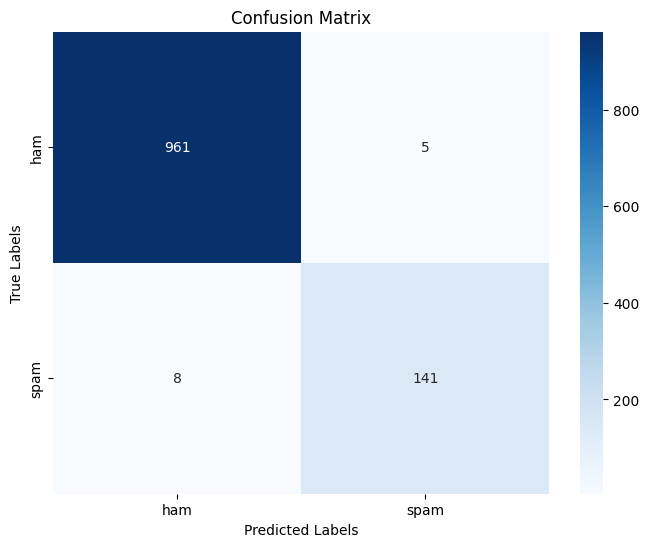

In [24]:
import seaborn as sns

# Plot confusion matrix with annotations
conf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [2]:
import pandas as pd

df = pd.read_csv('spam.csv')

print(df.shape)

(5572, 2)
